__Columns:__ 0:3 = One-Hot; 4:6 = C1'coord.; 7:12 = Ang.; 13:20 = Dihed.; 21:108 = C1' dist.; 109 = Rel.Seq.Pos.; 110 = Mask

In [1]:
import sys
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import Bio
from Bio import Align, Seq, SeqIO
aligner = Align.PairwiseAligner()
from tqdm import tqdm
import time

# PyTorch module, submodule, and associated functions
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from scipy.linalg import svd
from sklearn.model_selection import train_test_split

# My modules
import ../constants
from ../functions import seq_functions_01 as sf
from ../functions import structure_builder as sb

In [2]:
data_dir = 'np_data_02/'
file_list = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')])
N = len(file_list)
print(f'Total training sequences: {N}')
data_tensor = np.stack([np.load(f) for f in file_list])
print(f'Data tensor shape: {data_tensor.shape}')
data_tensor = np.nan_to_num(data_tensor, nan=0.0, posinf=1e6, neginf=-1e6)
print("NaNs still in NumPy array?", np.isnan(data_tensor).any())

Total training sequences: 279
Data tensor shape: (279, 88, 111)
NaNs still in NumPy array? False


In [3]:
X_data = data_tensor[:, :, np.r_[0:4,7:110]]  # all features except xyz and mask
y_data = data_tensor[:, :, 4:7]  # xyz coordinates
# mask_data = data_tensor[:, :, [110]]  # mask (used during loss)
mask_data = data_tensor[:, :, 110]  # mask (used during loss)

print(f"X shape: {X_data.shape} Expected: (279, 88, 107)")
print(f"y shape: {y_data.shape} Expected: (279, 88, 3)")
print(f"mask shape: {mask_data.shape} Expected: (279, 88)")

# print(f"NaNs in X_data:", np.isnan(X_data).any())
# print(f"NaNs in y_data:", np.isnan(y_data).any())
# print(f"NaNs in mask_data:", np.isnan(mask_data).any())

eps = 1e-8
mask_expanded = mask_data[..., np.newaxis]  # shape: (279, 88, 1)
# Zero out coordinates at gaps
masked_y = y_data * mask_expanded  # [279, 88, 3]
# Compute the center of mass (mean only over valid residues)
center = masked_y.sum(axis=1) / (mask_expanded.sum(axis=1) + eps)  # [279, 3]
# Subtract center from each residue
y_data_centered = y_data - center[:, np.newaxis, :]  # broadcasted
print("NaNs in y_data?", np.isnan(y_data_centered).any())
y_data_centered = np.nan_to_num(y_data_centered, nan=0.0, posinf=1e6, neginf=-1e6)
print("NaNs still in y_data?", np.isnan(y_data_centered).any())
# std = np.sqrt(((masked_y - center[:, np.newaxis, :]) ** 2).sum(axis=(1,2)) / (mask_data.sum(axis=1) * 3 + eps))
# y_data_centered /= std[:, np.newaxis, np.newaxis]

print(f"y centered shape: {y_data_centered.shape} Expected: (279, 88, 3)")

X shape: (279, 88, 107) Expected: (279, 88, 107)
y shape: (279, 88, 3) Expected: (279, 88, 3)
mask shape: (279, 88) Expected: (279, 88)
NaNs in y_data? False
NaNs still in y_data? False
y centered shape: (279, 88, 3) Expected: (279, 88, 3)


In [4]:
X_tensor = torch.tensor(X_data, dtype=torch.float32)
# y_tensor = torch.tensor(y_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data_centered, dtype=torch.float32)
mask_tensor = torch.tensor(mask_data, dtype=torch.float32)
print(y_tensor[0][mask_tensor[0].bool()].mean(dim=0))

print(f"X_tensor: {torch.isnan(X_tensor).any()} y_tensor: {torch.isnan(y_tensor).any()} mask_tensor: {torch.isnan(mask_tensor).any()}")
print("NaNs in X_tensor:", torch.isnan(X_tensor).any().item())
print("NaNs in y_tensor:", torch.isnan(y_tensor).any().item())
print("NaNs in mask_tensor:", torch.isnan(mask_tensor).any().item())

dataset = TensorDataset(X_tensor, y_tensor, mask_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

tensor([-2.2707e-08, -4.5413e-08,  2.2707e-08])
X_tensor: False y_tensor: False mask_tensor: False
NaNs in X_tensor: False
NaNs in y_tensor: False
NaNs in mask_tensor: False


In [5]:
class RNACoordModel(nn.Module):
    def __init__(self, input_dim=107, hidden_dim=128):
        super(RNACoordModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # output x, y, z
        )

    def forward(self, x):
        return self.encoder(x)  # input: [batch, 88, 107]; output: [batch, 88, 3]

In [6]:
# def masked_mse(pred, target, mask):
#     # pred, target: [batch, 88, 3]; mask: [batch, 88]
#     mse = (pred - target) ** 2           # [batch, 88, 3]
#     mse = mse.sum(dim=-1)                # [batch, 88]
#     masked = mse * mask                  # Apply mask
#     eps = 1e-8                           # to avoid division by zero
#     loss = masked.sum() / (mask.sum() + eps) # Mean over valid entries
#     return loss

# def masked_mse(pred, target, mask):
#     eps = 1e-8
#     mse = (pred - target) ** 2           # [batch, 88, 3]
#     masked = mse * mask.unsqueeze(-1)   # [batch, 88, 3]
#     loss = masked.sum() / (mask.sum() * 3 + eps)
#     return loss

def masked_mse(pred, target, mask):
    # Ensure mask is [batch, 88]
    if len(mask.shape) == 2:
        mask_exp = mask.unsqueeze(-1)     # [batch, 88, 1]
    elif len(mask.shape) == 1:
        mask = mask.unsqueeze(0)          # Add batch dim
        mask_exp = mask.unsqueeze(-1)
    else:
        raise ValueError("Unexpected mask shape")

    mse = (pred - target) ** 2            # [batch, 88, 3]
    masked = mse * mask_exp              # [batch, 88, 3]
    eps = 1e-8
    loss = masked.sum() / (mask.sum() * 3 + eps)
    return loss

def relative_geometry_loss(pred_xyz, true_xyz, mask):
    eps = 1e-8

    # mask: [batch, 88]
    mask = mask.unsqueeze(-1)  # [batch, 88, 1]

    # Apply mask to coords (zero out gaps)
    pred_xyz = pred_xyz * mask
    true_xyz = true_xyz * mask

    # Center coordinates (remove global position)
    pred_centered = pred_xyz - (pred_xyz.sum(dim=1, keepdim=True) / (mask.sum(dim=1, keepdim=True) + eps))
    true_centered = true_xyz - (true_xyz.sum(dim=1, keepdim=True) / (mask.sum(dim=1, keepdim=True) + eps))

    # Pairwise distance matrices
    pred_dist = torch.cdist(pred_centered, pred_centered, p=2)  # [batch, 88, 88]
    true_dist = torch.cdist(true_centered, true_centered, p=2)

    # Mask for valid distance pairs
    pair_mask = mask @ mask.transpose(1, 2)  # [batch, 88, 88]
    
    # Compute masked MSE over distances
    mse = ((pred_dist - true_dist) ** 2) * pair_mask
    loss = mse.sum() / (pair_mask.sum() + eps)
    return loss

def orientation_invariant_rmsd(pred, true, mask, eps=1e-8):
    batch_size = pred.shape[0]
    rmsd_list = []

    for b in range(batch_size):
        m = mask[b].bool()
        X = pred[b][m]
        Y = true[b][m]

        if X.shape[0] < 3:
            continue

        # Center
        X_mean = X.mean(dim=0)
        Y_mean = Y.mean(dim=0)
        X_centered = X - X_mean
        Y_centered = Y - Y_mean

        # Detach and convert to NumPy for SVD
        # C = (X_centered.T @ Y_centered).cpu().numpy()
        C = (X_centered.T @ Y_centered).detach().cpu().numpy()

        try:
            V, S, Wt = svd(C)
        except Exception as e:
            print(f"Skipping sample {b} due to SVD failure:", e)
            continue

        d = np.linalg.det(V @ Wt)
        D = np.diag([1.0, 1.0, d])
        U = torch.tensor(V @ D @ Wt, device=pred.device, dtype=pred.dtype)

        # Align X in PyTorch
        X_aligned = X_centered @ U

        diff = X_aligned - Y_centered
        rmsd = torch.sqrt((diff ** 2).sum() / X.shape[0] + eps)
        rmsd_list.append(rmsd)

    if len(rmsd_list) == 0:
        return (pred.sum() * 0.0) + 0.0  # maintain autograd graph

    return torch.stack(rmsd_list).mean()

In [7]:
def tm_score(pred_coords: torch.Tensor,
             true_coords: torch.Tensor,
             mask: torch.Tensor = None) -> torch.Tensor:
    """
    Computes TM-score between predicted and true coordinates.
    
    Args:
        pred_coords: (L, 3) predicted structure (should be aligned to reference)
        true_coords: (L, 3) reference structure
        mask: (L,) optional binary mask of valid positions
    
    Returns:
        TM-score (scalar tensor)
    """
    assert pred_coords.shape == true_coords.shape
    L = pred_coords.shape[0]

    if mask is None:
        mask = torch.ones(L, dtype=torch.float32, device=pred_coords.device)
    
    # Select valid residues
    valid = mask > 0
    pred = pred_coords[valid]
    true = true_coords[valid]
    L_valid = valid.sum().item()

    if L_valid == 0:
        return torch.tensor(0.0, device=pred_coords.device)

    # Compute distances
    dist = torch.norm(pred - true, dim=-1)  # shape: (L_valid,)

    # Avoid complex values if L_valid < 15
    L_clamped = max(L_valid, 19)  # to keep d0 real-valued and non-zero
    d0 = 1.24 * (L_clamped - 15)**(1/3) - 1.8
    d0 = max(d0, 0.5)

    score = 1.0 / (1.0 + (dist / d0) ** 2)
    return score.mean()

def soft_tm_loss(pred, true, mask, d0=1.24, eps=1e-8):
    """
    Differentiable TM-like loss: 1 - soft_TM_score
    """
    mask = mask.unsqueeze(-1)  # [B, L, 1]
    pred = pred * mask
    true = true * mask

    # Center
    pred_centered = pred - (pred.sum(dim=1, keepdim=True) / (mask.sum(dim=1, keepdim=True) + eps))
    true_centered = true - (true.sum(dim=1, keepdim=True) / (mask.sum(dim=1, keepdim=True) + eps))

    # Pairwise distances
    pred_dist = torch.cdist(pred_centered, pred_centered, p=2)
    true_dist = torch.cdist(true_centered, true_centered, p=2)

    # Avoid zero-distance pairs
    valid = (mask @ mask.transpose(1, 2)) > 0
    score = 1 / (1 + ((pred_dist - true_dist) / d0) ** 2)
    tm_loss = (1 - score)[valid].mean()

    return tm_loss


def lddt_torch(predicted_points: torch.Tensor,
               true_points: torch.Tensor,
               true_mask: torch.Tensor,
               cutoff: float = 15.0,
               per_residue: bool = False) -> torch.Tensor:
    """
    Computes approximate lDDT score between predicted and true 3D coordinates.

    Args:
        predicted_points: (L, 3) predicted 3D coordinates
        true_points: (L, 3) ground-truth 3D coordinates
        true_mask: (L,) binary tensor indicating valid positions
        cutoff: float, max distance in true structure to consider pair
        per_residue: bool, whether to return per-residue scores

    Returns:
        lDDT score (scalar) or (L,) tensor if per_residue=True
    """
    # Ensure proper shapes
    assert predicted_points.shape == true_points.shape
    assert predicted_points.shape[-1] == 3
    L = predicted_points.shape[0]

    # Mask reshaped for broadcasting
    true_mask = true_mask.float()
    mask_2d = true_mask[:, None] * true_mask[None, :]
    non_self = 1.0 - torch.eye(L, device=true_points.device)

    # Pairwise distances
    dmat_true = torch.cdist(true_points, true_points, p=2)
    dmat_pred = torch.cdist(predicted_points, predicted_points, p=2)

    # Mask for distances within cutoff in the *true* structure
    pair_mask = ((dmat_true < cutoff).float() *
                 mask_2d * non_self)

    # Absolute distance differences
    dist_l1 = torch.abs(dmat_true - dmat_pred)

    # Scoring: 4 thresholds
    score = 0.25 * ((dist_l1 < 0.5).float() +
                    (dist_l1 < 1.0).float() +
                    (dist_l1 < 2.0).float() +
                    (dist_l1 < 4.0).float())

    masked_score = pair_mask * score

    # Normalize
    if per_residue:
        norm = (pair_mask.sum(dim=1) + 1e-10)  # (L,)
        per_res_score = masked_score.sum(dim=1) / norm
        return per_res_score
    else:
        total_score = masked_score.sum()
        norm = pair_mask.sum() + 1e-10
        return total_score / norm

In [8]:
model = RNACoordModel(input_dim=107).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def composite_loss(pred, true, mask, w_rmsd=1.0, w_tm=1.0, w_lddt=0.2):
    rmsd = orientation_invariant_rmsd(pred, true, mask)
    tm = soft_tm_loss(pred, true, mask)
    lddt = relative_geometry_loss(pred, true, mask)
    return w_rmsd * rmsd + w_tm * tm + w_lddt * lddt

# loss_history = []
# rmse_history = []
# lddt_history = []
# tm_history = []

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0.0
#     batch_count = 0
#     lddt = []
#     tm = []
#     for batch_X, batch_Y, batch_mask in dataloader:
#         batch_X = batch_X.to(device)
#         batch_Y = batch_Y.to(device)
#         batch_mask = batch_mask.to(device)
        
#         optimizer.zero_grad()
#         preds = model(batch_X)
#         tm = [tm_score(pred_Y,Y,mask).item() for pred_Y,Y,mask in zip(preds,batch_Y,batch_mask)]
#         lddt = [lddt_torch(pred_Y,Y,mask) for pred_Y,Y,mask in zip(preds,batch_Y,batch_mask)]
#         # loss = orientation_invariant_rmsd(preds, batch_Y, batch_mask)
#         loss = composite_loss(preds, batch_Y, batch_mask, w_rmsd=1.0, w_tm=0.5, w_lddt=0.2)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
        
#         total_loss += loss.item()
#         batch_count += 1

#     ave_tm = np.mean(tm)
#     tm_history.append(ave_tm)
#     ave_lddt = np.mean(lddt)
#     lddt_history.append(ave_lddt)
#     avg_loss = total_loss / batch_count
#     rmse = torch.sqrt(loss).item()
#     loss_history.append(avg_loss)
#     rmse_history.append(rmse)
#     if epoch % 50 == 0:
#         print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f} - RMSE: {rmse:.4f}")
#         print(f"- LDDT: {ave_lddt:.4f} - TM_score: {ave_tm:.4f}")
# print(f"Epoch {epochs}/{epochs} - Average Loss: {loss_history[-1]:.4f}")
# print(f"- RMSE: {rmse_history[-1]:.4f} - TM_score: {ave_tm:.4f}")

loss_history = []
tm_history = []
lDDT_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_Y, batch_mask in dataloader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()
        preds = model(batch_X)

        loss = composite_loss(preds, batch_Y, batch_mask,
                              w_rmsd=1.0, w_tm=0.5, w_lddt=0.2)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    # Evaluate metrics on training data
    model.eval()
    tm_scores = []
    lddt_scores = []
    with torch.no_grad():
        for batch_X, batch_Y, batch_mask in dataloader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            batch_mask = batch_mask.to(device)

            preds = model(batch_X)

            for b in range(batch_X.shape[0]):
                tm = tm_score(preds[b], batch_Y[b], batch_mask[b])
                lddt = lddt_torch(preds[b], batch_Y[b], batch_mask[b])
                tm_scores.append(tm)
                lddt_scores.append(lddt)

    avg_tm = torch.stack(tm_scores).mean().item()
    avg_lddt = torch.stack(lddt_scores).mean().item()
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    lDDT_history.append(avg_lddt)
    tm_history.append(avg_tm)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | TM-score: {avg_tm:.4f} | lDDT: {avg_lddt:.4f}")
# print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | TM-score: {avg_tm:.4f} | lDDT: {avg_lddt:.4f}")

Epoch 50/500 - Loss: 43.9613 | TM-score: 0.0007 | lDDT: 0.3614
Epoch 100/500 - Loss: 23.8574 | TM-score: 0.0021 | lDDT: 0.4060
Epoch 150/500 - Loss: 20.4270 | TM-score: 0.0030 | lDDT: 0.4620
Epoch 200/500 - Loss: 14.7519 | TM-score: 0.0031 | lDDT: 0.4800
Epoch 250/500 - Loss: 12.2470 | TM-score: 0.0037 | lDDT: 0.5071
Epoch 300/500 - Loss: 10.5344 | TM-score: 0.0036 | lDDT: 0.5353
Epoch 350/500 - Loss: 10.5331 | TM-score: 0.0041 | lDDT: 0.5520
Epoch 400/500 - Loss: 9.0916 | TM-score: 0.0042 | lDDT: 0.5600
Epoch 450/500 - Loss: 7.4473 | TM-score: 0.0047 | lDDT: 0.6007
Epoch 500/500 - Loss: 7.5826 | TM-score: 0.0043 | lDDT: 0.6147


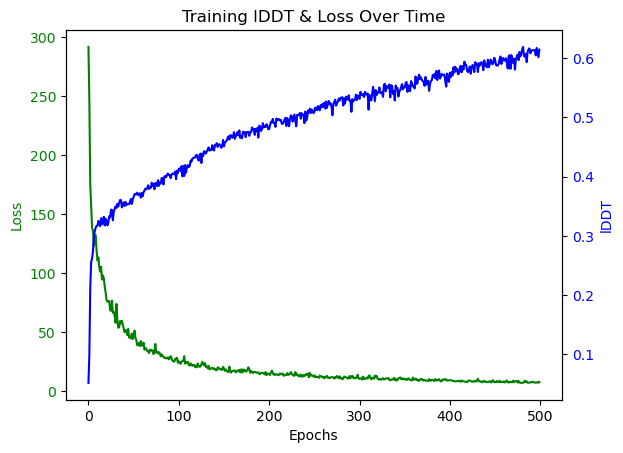

In [10]:
# lDDT and TM closer to 1.0 == Better!

fig, ax1 = plt.subplots()
ax1.plot(loss_history, color='g')
plt.xlabel("Epochs")
ax1.set_ylabel("Loss", color='g')
ax1.tick_params(axis='y', labelcolor='g')
plt.title("Training lDDT & Loss Over Time")
ax2 = ax1.twinx()
ax2.plot(lDDT_history, color='b')
ax2.set_ylabel("lDDT", color='b')
ax2.tick_params(axis='y', labelcolor='b')
# ax3 = ax1.twinx()
# ax3.plot(ave_rmse_history, color='r')
# # ax3.set_ylabel("Ave. RMSE", color='r')
# ax2.tick_params(axis='y', labelcolor='r')
plt.show()

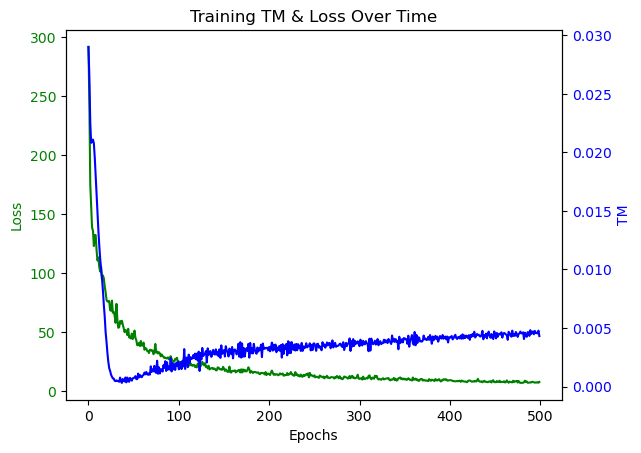

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(loss_history, color='g')
plt.xlabel("Epochs")
ax1.set_ylabel("Loss", color='g')
ax1.tick_params(axis='y', labelcolor='g')
plt.title("Training TM & Loss Over Time")
ax2 = ax1.twinx()
ax2.plot(tm_history, color='b')
ax2.set_ylabel("TM", color='b')
ax2.tick_params(axis='y', labelcolor='b')
# ax3 = ax1.twinx()
# ax3.plot(ave_rmse_history, color='r')
# # ax3.set_ylabel("Ave. RMSE", color='r')
# ax2.tick_params(axis='y', labelcolor='r')
plt.show()

In [12]:
def coords_to_pdb(coords, mask=None, chain_id='A', residue_name='A', atom_name="C1'", start_res=1):
    """
    coords: numpy array of shape [88, 3]
    mask: optional 1D array of shape [88] to exclude gaps (0s)
    Returns: string with PDB lines
    """
    pdb_lines = []
    atom_num = 1
    res_num = start_res

    for i in range(coords.shape[0]):
        if mask is not None and mask[i] == 0:
            continue

        x, y, z = coords[i]
        line = (
            f"ATOM  {atom_num:5d} {atom_name:<4} {residue_name:>3} {chain_id}{res_num:4d}    "
            f"{x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           C"
        )
        pdb_lines.append(line)
        atom_num += 1
        res_num += 1

    pdb_lines.append("END")
    return "\n".join(pdb_lines)

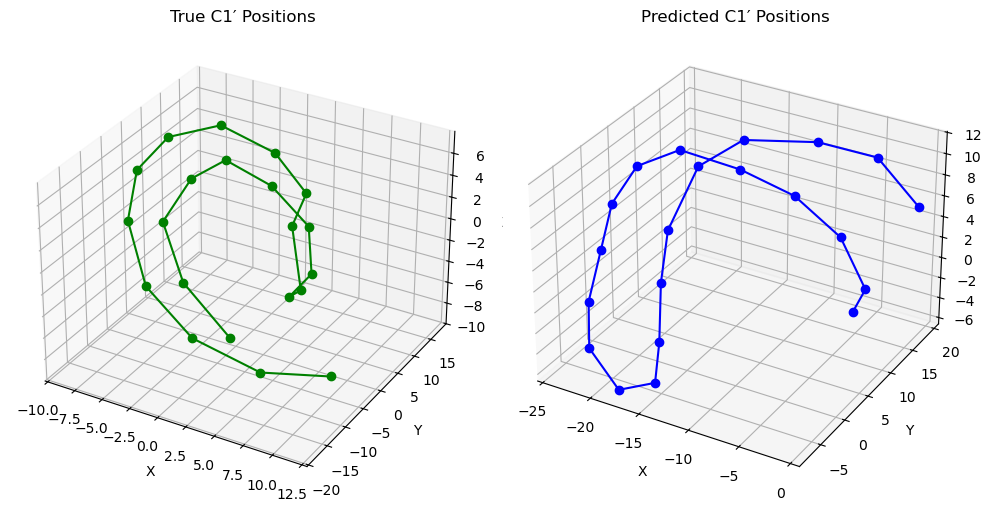

In [13]:
model.eval()
# from functions import seq_functions_01 as sf
with torch.no_grad():
    test_X = X_tensor[0].unsqueeze(0).to(device)
    test_Y_true = y_tensor[0].cpu().numpy()
    test_mask = mask_tensor[0].cpu().numpy()
    pred_Y = model(test_X).squeeze(0).cpu().numpy()

# Generate PDB strings
pdb_true = coords_to_pdb(test_Y_true, mask=test_mask, chain_id='A', residue_name='TRU', atom_name="C1'")
pdb_pred = coords_to_pdb(pred_Y, mask=test_mask, chain_id='B', residue_name='PRD', atom_name="C1'")

# Save to files
with open("model_eval_V01/true_coords.pdb", "w") as f:
    f.write(pdb_true)

with open("model_eval_V01/pred_coords.pdb", "w") as f:
    f.write(pdb_pred)

# Apply mask to only show real residues
pred_points = pred_Y[test_mask.astype(bool)]
true_points = test_Y_true[test_mask.astype(bool)]

fig = plt.figure(figsize=(10, 5))

# True structure
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(true_points[:, 0], true_points[:, 1], true_points[:, 2], 'o-', label='True', color='green')
ax1.set_title('True C1′ Positions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Predicted structure
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(pred_points[:, 0], pred_points[:, 1], pred_points[:, 2], 'o-', label='Predicted', color='blue')
ax2.set_title('Predicted C1′ Positions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

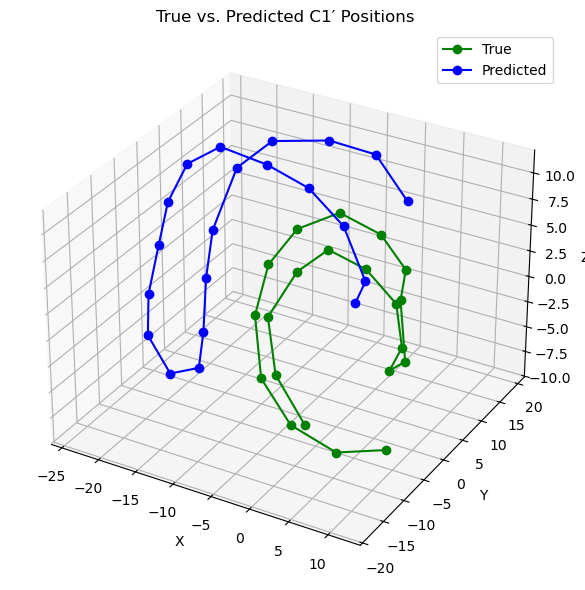

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(true_points[:, 0], true_points[:, 1], true_points[:, 2], 'o-', label='True', color='green')
ax.plot(pred_points[:, 0], pred_points[:, 1], pred_points[:, 2], 'o-', label='Predicted', color='blue')

ax.set_title('True vs. Predicted C1′ Positions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.tight_layout()
plt.show()